# W207 Group Project - What's Cooking?

Group members: Daniel Volk, Aaron Yuen

Kaggle competition link: https://www.kaggle.com/c/whats-cooking

## Business Understanding

#### Description from Kaggle:

Picture yourself strolling through your local, open-air market... What do you see? What do you smell? What will you make for dinner tonight?

If you're in Northern California, you'll be walking past the inevitable bushels of leafy greens, spiked with dark purple kale and the bright pinks and yellows of chard. Across the world in South Korea, mounds of bright red kimchi greet you, while the smell of the sea draws your attention to squids squirming nearby. India’s market is perhaps the most colorful, awash in the rich hues and aromas of dozens of spices: turmeric, star anise, poppy seeds, and garam masala as far as the eye can see.

Some of our strongest geographic and cultural associations are tied to a region's local foods. This playground competitions asks you to predict the category of a dish's cuisine given a list of its ingredients. 

#### What problem are we trying to solve?

The problem at hand is to categorize the cuisine of a recipe based on the provided list of ingredients. This competition was hosted by Yummly, a company that builds a mobile app and website that provides recipe recommendations personalized to the individual's tastes. This is a multi-class classification problem where the input is a list of strings (ingredients) and the output we are trying to predict is one of the various classes of cuisine. 

#### What are the relevant metrics?

In this classification problem, there are a few relevant metrics we will explore:
1. Accuracy
2. Precision
3. Recall

#### How do we plan to improve these metrics?

We will start by establishing a baseline using a very simple classifier with little parameter tuning and feature engineering.  Once we have established a baseline, we will then build upon it with trying various models, tuning various hyper-parameters, and spend considerable effects in feature engineering. We will also iterate through error analysis, which will also be shared in this deliverable as well.

MORE HERE ON SPECIFIC TECHNIQUES WE WILL TRY

#### What will we deliver?

The main deliverable is this iPython notebook that completes the full end-to-end project from problem scope, data understanding, exploratory analysis, baseline model, feature engineering, error analysis and final results.

## Data Understanding

#### Library Imports

In [18]:
# Loading all relevant libraries
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import re

matplotlib.rc('font', **{'weight' : 'bold', 'size':10} )

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, precision_score, recall_score, f1_score, auc
import string

#### Data Loading

The provided sources of data from the competition are:

1. train.json - Includes both the list of ingredients as features and the cuisine as the class
2. test.json - Includes only the list of ingredients as features. The cuisine (e.g. the class) is not present.


In [2]:
# Read train and test dataset from the provided JSONs
train = pd.read_json("data/train.json")
test = pd.read_json("data/test.json")

# Separate to raw features dataframe
X_train_all = train["ingredients"]
X_test = test["ingredients"]

# Separate label dataframe
y_train_all = train["cuisine"]

In [3]:
print(X_train_all.shape)
print(y_train_all.shape)

(39774,)
(39774,)


#### Example features and labels

In [4]:
print("First 10 example features from the training set")
print(X_train_all.head(10))
print("")

print("First 10 example labels from the training set")
print(y_train_all.head(10))
print("")

print("First 10 example features from the test set")
print(X_test.head(10))
print("")

First 10 example features from the training set
0    [romaine lettuce, black olives, grape tomatoes...
1    [plain flour, ground pepper, salt, tomatoes, g...
2    [eggs, pepper, salt, mayonaise, cooking oil, g...
3                  [water, vegetable oil, wheat, salt]
4    [black pepper, shallots, cornflour, cayenne pe...
5    [plain flour, sugar, butter, eggs, fresh ginge...
6    [olive oil, salt, medium shrimp, pepper, garli...
7    [sugar, pistachio nuts, white almond bark, flo...
8    [olive oil, purple onion, fresh pineapple, por...
9    [chopped tomatoes, fresh basil, garlic, extra-...
Name: ingredients, dtype: object

First 10 example labels from the training set
0          greek
1    southern_us
2       filipino
3         indian
4         indian
5       jamaican
6        spanish
7        italian
8        mexican
9        italian
Name: cuisine, dtype: object

First 10 example features from the test set
0    [baking powder, eggs, all-purpose flour, raisi...
1    [sugar, egg yolks,

In [5]:
# Check for nulls in the ingredients column
(X_train_all.isnull()).sum()

0

#### Distribution of training classes

Here we can see that there is a high imbalance of classes, with majority of the cuisine to be Italian, Mexican, and Southern US. We'll need to ensure in the data preparation step that these are more balanced before training.

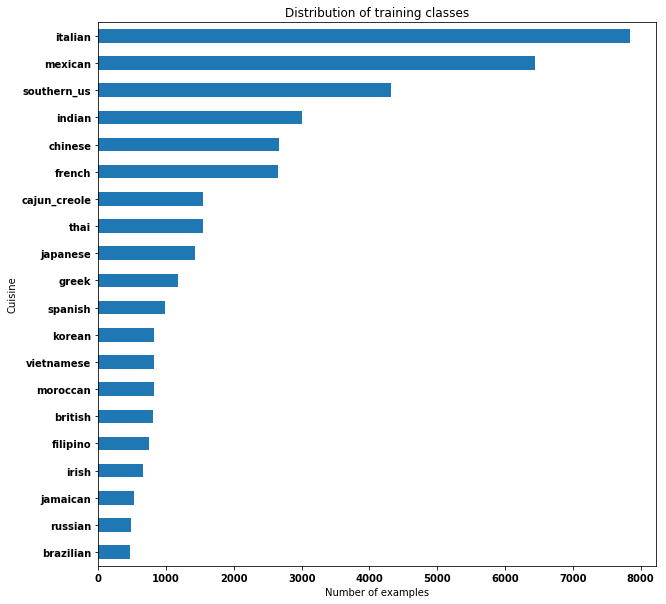

In [6]:
# Plot distribution of training classes
plt.figure(figsize=(10,10))
f = y_values = y_train_all.value_counts().plot(kind='barh')
f.invert_yaxis()
plt.title("Distribution of training classes")
plt.ylabel("Cuisine")
plt.xlabel("Number of examples");

#### Number of Ingredients per Recipe

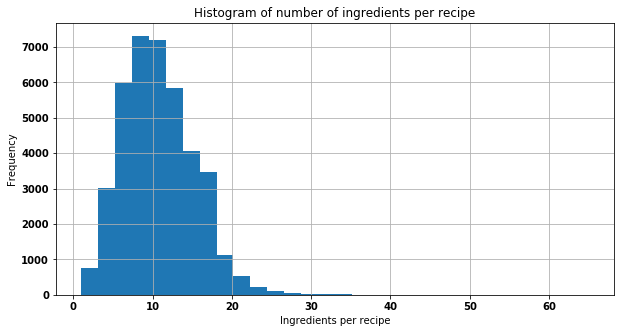

In [7]:
plt.figure(figsize=(10,5))
f = X_train_all.apply(len).hist(bins=30)
plt.title("Histogram of number of ingredients per recipe")
plt.ylabel("Frequency")
plt.xlabel("Ingredients per recipe");

#### Top Ingredients - Across All Cuisines

The top ingredients seem to be very common ingredients like salt, sugar, oil, etc. which may not be cusine-specific. These features could potentially be ruled out (or let the model feature-select). Here we can also see that there are similar ingredients that should be deduplicated (e.g. kosher salt and salt, olive oil and oil). 

In [8]:
# For each row, go through each ingredient and create a cuisine-ingredient pair
ing_cuisine_pair = []
for i in range(X_train_all.shape[0]):
    for ingredient in X_train_all[i]:
        ing_cuisine_pair.append([y_train_all[i], ingredient])

ing_cuisine = pd.DataFrame(ing_cuisine_pair, columns=['cuisine', 'ingredient'])

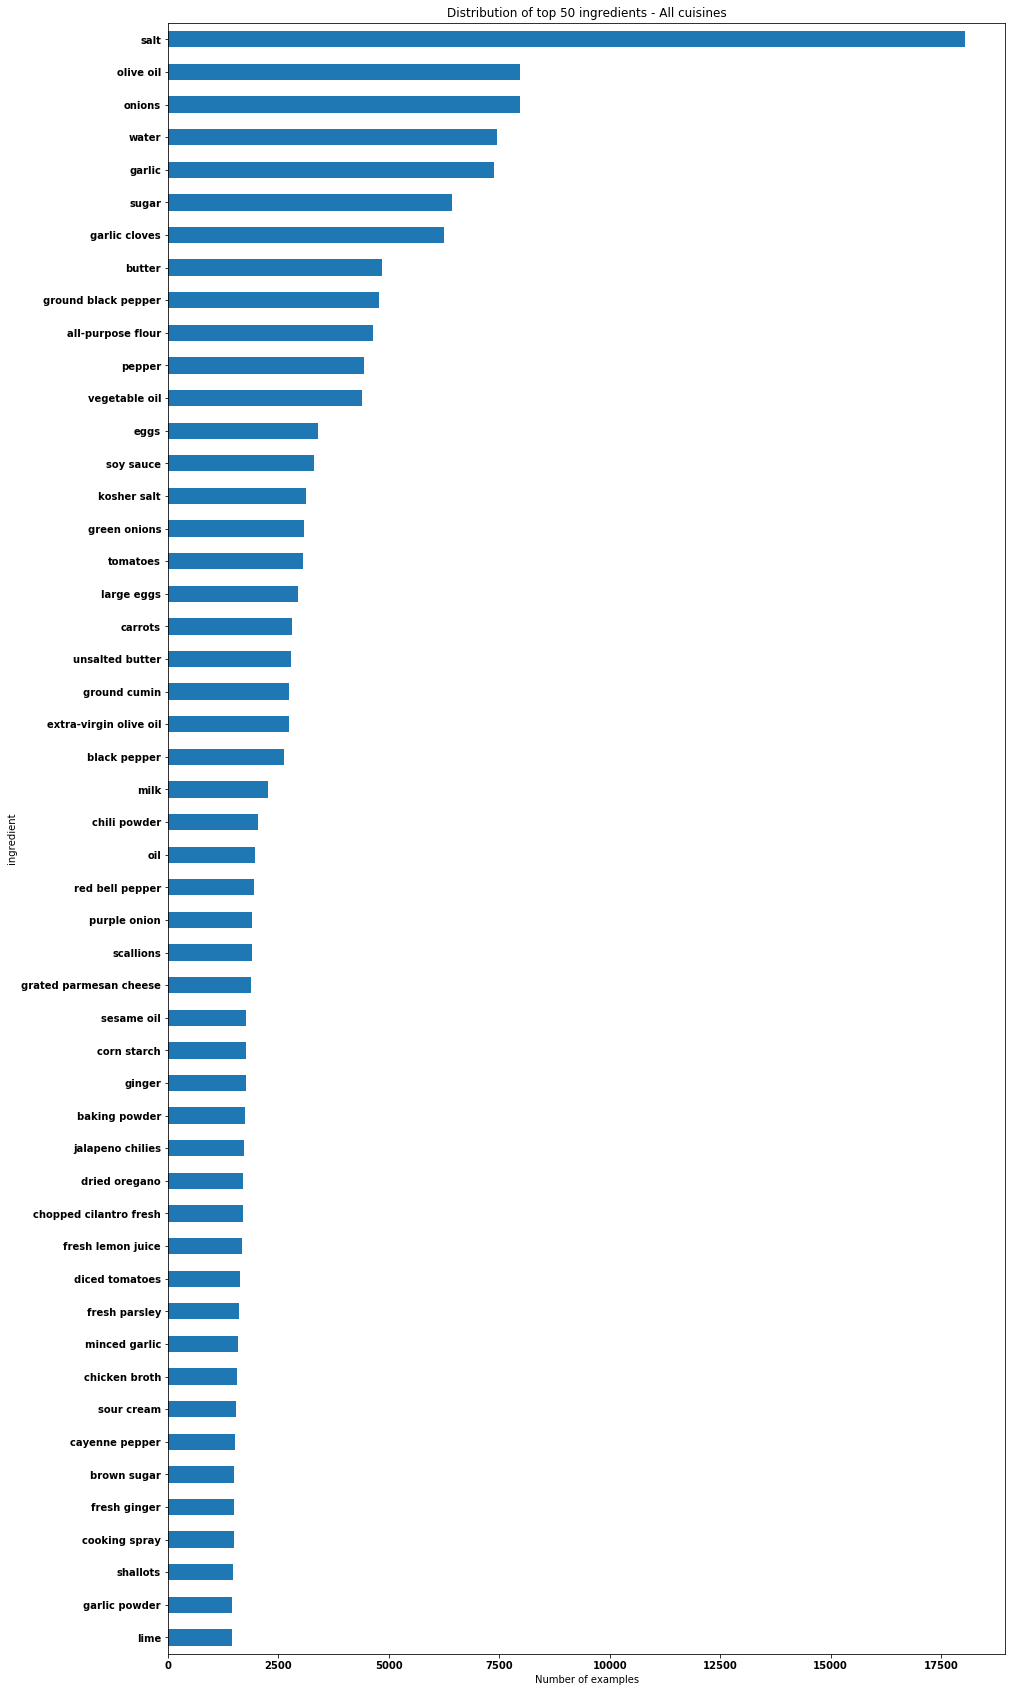

In [9]:
plt.figure(figsize=(15,30))
plt.title("Distribution of top 50 ingredients - All cuisines")
plt.ylabel("ingredient")
plt.xlabel("Number of examples")
f = ing_cuisine['ingredient'].value_counts()[:50].plot(kind='barh')
f.invert_yaxis()

#### Top Ingredients - By Cuisine

Similarly, here by cuisine the top ingredients are common ingredients like salt, but we start to see some cuisine-specific incredients like jalapeno chilies for Mexican and soy sauce for Chinese.

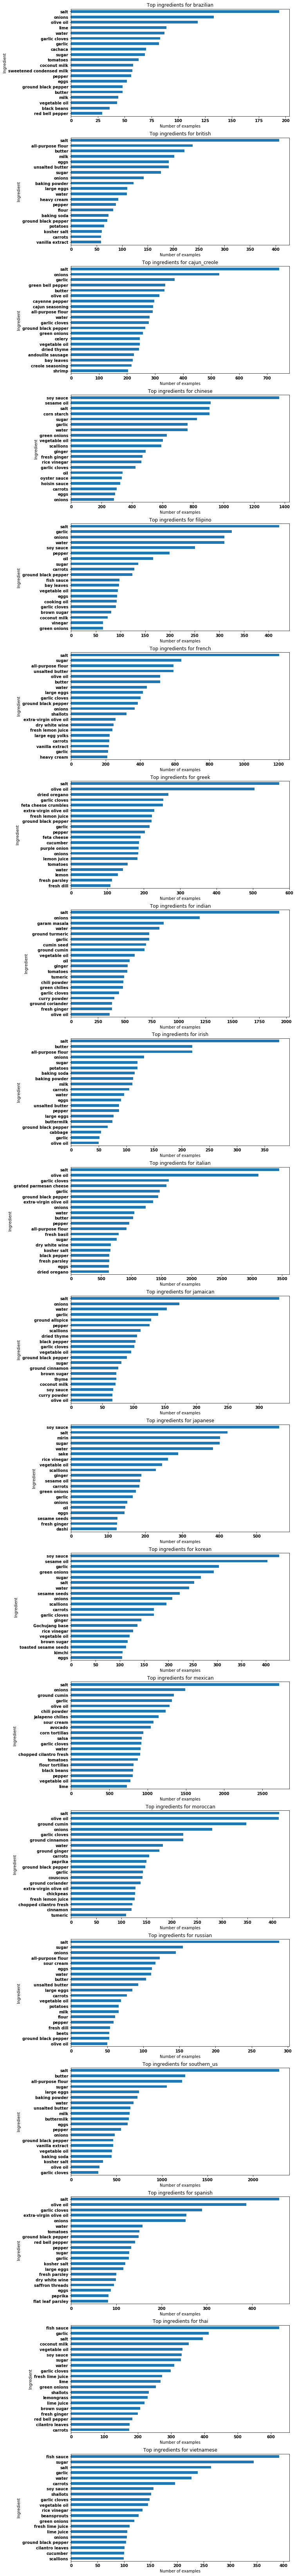

In [10]:
# Top ingredients by cuisine
plt.figure(figsize=(10,120))

grouped = ing_cuisine.groupby('cuisine')

cuisines = list(grouped.groups.keys())
for i in range(len(cuisines)):
    plt.subplot(20, 1, i+1)
    
    f = ing_cuisine[ing_cuisine['cuisine'] == cuisines[i]]['ingredient'].value_counts()[:20].plot(kind='barh')
    f.invert_yaxis()
    plt.title("Top ingredients for %s" % cuisines[i])
    plt.ylabel("Ingredient")
    plt.xlabel("Number of examples")
    i+=1

plt.show()

#### Unique ingredients

In [13]:
d = pd.DataFrame(ing_cuisine['ingredient'].value_counts())
print(d)

                                             ingredient
salt                                              18049
olive oil                                          7972
onions                                             7972
water                                              7457
garlic                                             7380
sugar                                              6434
garlic cloves                                      6237
butter                                             4848
ground black pepper                                4785
all-purpose flour                                  4632
pepper                                             4438
vegetable oil                                      4385
eggs                                               3388
soy sauce                                          3296
kosher salt                                        3113
green onions                                       3078
tomatoes                                        

## Baseline Data Preparation

In [14]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train_all, y_train_all, random_state=2)

In [15]:
print("The shape of X_train is", X_train.shape)
print("The shape of X_dev is ", X_dev.shape)
print("The shape of y_train is", y_train.shape)
print("The shape of y_dev is", y_dev.shape)

The shape of X_train is (29830,)
The shape of X_dev is  (9944,)
The shape of y_train is (29830,)
The shape of y_dev is (9944,)


In [16]:
def list_to_string(l):
    return ','.join(l).replace(' ', '_').replace('|', ' ')

X_train_str = X_train.apply(list_to_string)
X_dev_str = X_dev.apply(list_to_string)

## Baseline Model

#### Training

For the baseline model, we are starting with a very simple logistic regression model with no hyperparameter tuning. We will also be using a very basic count vectorizer. The goal of this is really to establish a baseline and understand what the metrics are for this very basic model.

In [37]:
base_pipeline = Pipeline(steps=[
    ('countvectorizer', CountVectorizer()),
    ('lr', LogisticRegression()),
])
base_pipeline.fit(X_train_str, y_train)

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

#### Evaluation - Accuracy

Note that accuracy is NOT a good measure here especially given that there is high class imbalance. This is only calculated to establish a baseline.

In [38]:
print("Accuracy of the base model on the training data is", base_pipeline.score(X_train_str, y_train))
print("Accuracy of the base model on the dev data is", base_pipeline.score(X_dev_str, y_dev))

Accuracy of the base model on the training data is 0.876567214214
Accuracy of the base model on the dev data is 0.776850362027


#### Evaluation - Precision & Recall

Precision and recall are better measures to use here with high class imbalance.

In [39]:
y_pred = base_pipeline.predict(X_dev_str)
print("Precision of the base model is", precision_score(y_dev, y_pred, average='macro'))
print("Recall of the base model is", recall_score(y_dev, y_pred, average='macro'))
print("Recall of the base model is", f1_score(y_dev, y_pred, average='macro'))

Precision of the base model is 0.753728440323
Recall of the base model is 0.659289626281
Recall of the base model is 0.695687733957


#### Confusion matrix

In [40]:
conf_mat = confusion_matrix(y_dev, y_pred)
conf_mat_abs = pd.DataFrame(conf_mat, index=base_pipeline.classes_, columns=base_pipeline.classes_)
display(conf_mat_abs)
conf_mat_perc = pd.DataFrame((conf_mat.T/conf_mat.sum(axis=1)).T, index=base_pipeline.classes_, columns=base_pipeline.classes_)
display(conf_mat_perc)

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
brazilian,64,0,2,0,2,4,0,4,0,6,5,0,0,17,0,1,9,3,4,0
british,2,65,1,1,0,37,1,7,9,16,0,1,1,3,0,4,56,2,0,0
cajun_creole,1,3,267,1,0,10,1,1,0,25,0,0,1,8,0,1,56,1,0,0
chinese,0,0,2,556,11,4,0,8,0,8,1,19,12,7,1,2,9,0,18,12
filipino,4,0,0,18,113,4,0,1,2,8,1,0,1,8,0,1,16,1,6,6
french,0,4,5,1,2,407,9,3,8,119,0,1,0,6,4,4,52,11,0,0
greek,0,0,0,0,0,6,172,4,0,58,0,1,0,1,4,1,5,6,0,0
indian,1,0,1,3,2,5,4,666,0,15,0,10,0,19,15,0,4,0,13,0
irish,0,15,0,1,0,21,1,2,70,21,0,0,0,2,0,2,38,1,1,0
italian,0,6,5,1,1,84,18,6,2,1764,0,0,0,19,5,0,45,6,1,0


,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
brazilian,0.528926,0.000000,0.016529,0.000000,0.016529,0.033058,0.000000,0.033058,0.000000,0.049587,0.041322,0.000000,0.000000,0.140496,0.000000,0.008264,0.074380,0.024793,0.033058,0.000000
british,0.009709,0.315534,0.004854,0.004854,0.000000,0.179612,0.004854,0.033981,0.043689,0.077670,0.000000,0.004854,0.004854,0.014563,0.000000,0.019417,0.271845,0.009709,0.000000,0.000000
cajun_creole,0.002660,0.007979,0.710106,0.002660,0.000000,0.026596,0.002660,0.002660,0.000000,0.066489,0.000000,0.000000,0.002660,0.021277,0.000000,0.002660,0.148936,0.002660,0.000000,0.000000
chinese,0.000000,0.000000,0.002985,0.829851,0.016418,0.005970,0.000000,0.011940,0.000000,0.011940,0.001493,0.028358,0.017910,0.010448,0.001493,0.002985,0.013433,0.000000,0.026866,0.017910
filipino,0.021053,0.000000,0.000000,0.094737,0.594737,0.021053,0.000000,0.005263,0.010526,0.042105,0.005263,0.000000,0.005263,0.042105,0.000000,0.005263,0.084211,0.005263,0.031579,0.031579
french,0.000000,0.006289,0.007862,0.001572,0.003145,0.639937,0.014151,0.004717,0.012579,0.187107,0.000000,0.001572,0.000000,0.009434,0.006289,0.006289,0.081761,0.017296,0.000000,0.000000
greek,0.000000,0.000000,0.000000,0.000000,0.000000,0.023256,0.666667,0.015504,0.000000,0.224806,0.000000,0.003876,0.000000,0.003876,0.015504,0.003876,0.019380,0.023256,0.000000,0.000000
indian,0.001319,0.000000,0.001319,0.003958,0.002639,0.006596,0.005277,0.878628,0.000000,0.019789,0.000000,0.013193,0.000000,0.025066,0.019789,0.000000,0.005277,0.000000,0.017150,0.000000
irish,0.000000,0.085714,0.000000,0.005714,0.000000,0.120000,0.005714,0.011429,0.400000,0.120000,0.000000,0.000000,0.000000,0.011429,0.000000,0.011429,0.217143,0.005714,0.005714,0.000000
italian,0.000000,0.003057,0.002547,0.000509,0.000509,0.042792,0.009170,0.003057,0.001019,0.898625,0.000000,0.000000,0.000000,0.009679,0.002547,0.000000,0.022924,0.003057,0.000509,0.000000


In [51]:
df_samples = pd.DataFrame([X_dev, y_dev]).transpose()
df_samples['y_pred'] = base_pipeline.predict(X_dev_str)
df_samples[df_samples['cuisine']!=df_samples['y_pred']].head(10)

,ingredients,cuisine,y_pred
3981,"[water, oil, salt, baking powder, flour]",jamaican,indian
11701,"[sugar, salt, bread flour, rapid rise yeast, b...",spanish,southern_us
11206,"[ground black pepper, cod fish, tomatoes, baki...",jamaican,mexican
37973,"[black pepper, hot sauce, white vinegar, garli...",chinese,thai
26699,"[fresh basil, water, dry white wine, bay leaf,...",french,italian
19885,"[shortening, confectioners sugar, rose water, ...",moroccan,italian
24764,"[dressing, chicken breast halves, plum tomatoe...",southern_us,mexican
21670,"[all-purpose flour, sparkling sugar, butter, d...",irish,southern_us
13136,"[red wine vinegar, fresh oregano, olives, blac...",french,greek
28418,"[green onions, cheese, coarse salt, russet pot...",french,mexican


In [57]:
df = pd.DataFrame([X_train, y_train]).transpose()
df['count'] = df['ingredients'].apply(len)
df.groupby('cuisine').mean()

,count
cuisine,
brazilian,9.346821
british,9.715719
cajun_creole,12.566667
chinese,11.981028
filipino,10.104425
french,9.824876
greek,10.155943
indian,12.682405
irish,9.278455


## Logistic Regression - Model 2

In [55]:
def list_to_string(l):
    l = [re.sub('[^A-Za-z]',' ',x).strip() for x in l]
    return ','.join(l).replace(' ', '_').replace('|', ' ')

X_train_str = X_train.apply(list_to_string)
X_dev_str = X_dev.apply(list_to_string)

In [56]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV

#### Training

For the second model we update the vectorizer and apply regularization to account for potential overfitting.

In [64]:
model2_pipeline = Pipeline(steps=[
    ('cv', CountVectorizer()),
    ('lr', LogisticRegression()),
])

# search_params = {
#     #'countvectorizer__ngram_range': [(1,1), (1,2), (1,3), (1,4)],
#     'countvectorizer__min_df': [0.0001,],
#     'lr__class_weight': ['balanced',],
#     'lr__C': [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]
# }

# grid_search = GridSearchCV(model2_pipeline, search_params, verbose=2)
model2_pipeline.fit(X_train_str, y_train)
# grid_search.best_params_

Pipeline(memory=None,
     steps=[('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_a...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

#### Evaluation - Accuracy

Note that accuracy is NOT a good measure here especially given that there is high class imbalance. This is only calculated to establish a baseline.

In [65]:
print("Accuracy of the model 2 on the dev data", model2_pipeline.score(X_dev_str, y_dev))
print("Accuracy of the model 2 on the train data", model2_pipeline.score(X_train_str, y_train))

Accuracy of the model 2 on the dev data 0.77664923572
Accuracy of the model 2 on the train data 0.87589674824


#### Evaluation - Precision & Recall

Precision and recall are better measures to use here with high class imbalance.

In [151]:
y_pred = model2_pipeline.predict(X_dev)
print("Precision of the model is", precision_score(y_dev, y_pred, average='macro'))
print("Recall of the model is", recall_score(y_dev, y_pred, average='macro'))

Precision of the model is 0.772866965028
Recall of the model is 0.564118363916


#### Confusion matrix

In [152]:
pandas.DataFrame(confusion_matrix(y_dev, y_pred), index=model2_pipeline.classes_, columns=model2_pipeline.classes_)

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
brazilian,34,0,3,0,1,7,0,5,1,11,1,0,0,28,0,0,22,1,7,0
british,0,37,0,1,1,46,0,8,6,25,0,0,0,6,1,1,74,0,0,0
cajun_creole,0,2,242,3,0,17,0,0,0,28,0,0,0,18,0,0,65,1,0,0
chinese,0,1,1,577,5,4,0,7,0,15,0,9,8,9,0,0,16,0,11,7
filipino,0,1,0,23,87,3,0,2,1,18,0,0,0,10,0,0,31,1,11,2
french,0,1,5,1,2,349,3,2,4,181,0,1,0,11,1,1,68,6,0,0
greek,0,1,0,0,0,2,147,5,0,79,0,0,0,3,3,1,14,3,0,0
indian,0,0,0,2,1,1,4,654,0,32,0,0,0,33,9,1,12,1,8,0
irish,0,8,0,1,0,30,1,2,41,28,1,0,0,2,0,1,60,0,0,0
italian,0,1,5,2,0,61,11,7,0,1793,0,0,0,26,3,0,52,2,0,0


# Naive Bayes - Model 3

In [20]:

from sklearn.preprocessing import FunctionTransformer

#### Training

For the second model we update the vectorizer and apply regularization to account for potential overfitting.

In [61]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

model2_pipeline = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words='english',ngram_range = ( 1 , 1 ),analyzer="word", max_df = .57 , 
                              binary=False ,max_features =6706, token_pattern=r'\w+' , sublinear_tf=False)),
    ('mnb', MultinomialNB()),
])

search_params = {
    'mnb__alpha': np.linspace(0.01,0.2,10)
}

grid_search = GridSearchCV(model2_pipeline, search_params, verbose=1)
grid_search.fit(X_train_str, y_train)
grid_search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

#### Evaluation - Accuracy

Note that accuracy is NOT a good measure here especially given that there is high class imbalance. This is only calculated to establish a baseline.

In [25]:
print("Accuracy of the model 2 on the dev data", grid_search.score(X_dev_str, y_dev))
print("Accuracy of the model 2 on the train data", grid_search.score(X_train_str, y_train))

Accuracy of the model 2 on the dev data 0.748491552695
Accuracy of the model 2 on the train data 0.840429098223


#### Evaluation - Precision & Recall

Precision and recall are better measures to use here with high class imbalance.

In [27]:
y_pred = grid_search.predict(X_dev_str)
print("Precision of the model is", precision_score(y_dev, y_pred, average='macro'))
print("Recall of the model is", recall_score(y_dev, y_pred, average='macro'))
print("F1 score of the model is", f1_score(y_dev, y_pred, average='macro'))

Precision of the model is 0.755487386568
Recall of the model is 0.610915349173
F1 score of the model is 0.658643609964


#### Confusion matrix

In [152]:
pandas.DataFrame(confusion_matrix(y_dev, y_pred), index=model2_pipeline.classes_, columns=model2_pipeline.classes_)

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
brazilian,34,0,3,0,1,7,0,5,1,11,1,0,0,28,0,0,22,1,7,0
british,0,37,0,1,1,46,0,8,6,25,0,0,0,6,1,1,74,0,0,0
cajun_creole,0,2,242,3,0,17,0,0,0,28,0,0,0,18,0,0,65,1,0,0
chinese,0,1,1,577,5,4,0,7,0,15,0,9,8,9,0,0,16,0,11,7
filipino,0,1,0,23,87,3,0,2,1,18,0,0,0,10,0,0,31,1,11,2
french,0,1,5,1,2,349,3,2,4,181,0,1,0,11,1,1,68,6,0,0
greek,0,1,0,0,0,2,147,5,0,79,0,0,0,3,3,1,14,3,0,0
indian,0,0,0,2,1,1,4,654,0,32,0,0,0,33,9,1,12,1,8,0
irish,0,8,0,1,0,30,1,2,41,28,1,0,0,2,0,1,60,0,0,0
italian,0,1,5,2,0,61,11,7,0,1793,0,0,0,26,3,0,52,2,0,0


## SVM

#### Training

For the baseline model, we are starting with a very simple logistic regression model with no hyperparameter tuning. We will also be using a very basic count vectorizer. The goal of this is really to establish a baseline and understand what the metrics are for this very basic model.

In [19]:
def list_to_string(l):
    l = [re.sub('[^A-Za-z]',' ',x).strip() for x in l]
    return ','.join(l).replace(' ', '_').replace('|', ' ')

X_train_str = X_train.apply(list_to_string)
X_dev_str = X_dev.apply(list_to_string)

In [72]:
X_train_str[X_train_str=='water,grits,whole_milk,unsalted_butter,kosher_salt,heavy_cream']

X_train_str.sort_index(ascending=False).head(10)

39773    green_chile,jalapeno_chilies,onions,ground_bla...
39772    boneless_chicken_skinless_thigh,minced_garlic,...
39771    eggs,citrus_fruit,raisins,sourdough_starter,fl...
39770    KRAFT_Zesty_Italian_Dressing,purple_onion,broc...
39769    light_brown_sugar,granulated_sugar,butter,warm...
39768    shredded_cheddar_cheese,crushed_cheese_cracker...
39767    low_fat_sour_cream,grated_parmesan_cheese,salt...
39766    rutabaga,ham,thick_cut_bacon,potatoes,fresh_pa...
39765    coconut,unsweetened_coconut_milk,mint_leaves,p...
39764    chili_powder,worcestershire_sauce,celery,red_k...
Name: ingredients, dtype: object

In [84]:
ci.fit_transform(X_train_str)

25523     3
17741     9
34853    17
19235     9
22062     8
13206    10
11490     6
562      13
11851     8
4271     23
2042     10
25336    15
19262    10
9202     11
9401      5
25295     9
18332    10
18025    18
13635    10
26533    21
27898     8
29725    13
17854    14
11215    12
3017     16
1934     14
20788     6
27292     6
20242    12
2754      6
         ..
30257    10
19775    11
12420    12
19694    10
36432     8
16415    17
27859    12
25902     7
16639     6
21372    11
20026    12
15905     6
8170      9
29547    18
21418    17
20084    12
6548      8
32031    11
11071     7
5167     12
35541     6
33201    10
14696     6
33867    11
18898    12
31019     9
30280    10
6637      7
35343     6
23720     6
Name: ingredients, Length: 29830, dtype: int64

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer

def count_ingredients(x):
    return len(re.findall(',', str(x)))+1

ci = FunctionTransformer(count_ingredients, validate=False)

tfidf = TfidfVectorizer(max_df=0.45, 
                        stop_words='english', 
                        analyzer="word", 
                        token_pattern=r'\w+', 
                        max_features=5500)

extract_featues = FeatureUnion([("ci", ci), ("tfidf", tfidf)])

svc_pipe = Pipeline(steps=[
    ('ef', FeatureUnion([
        ('tfidf', tfidf), # can pass in either a pipeline
        ('ci', ci) # or a transformer
    ])),
    ('svm', LinearSVC(penalty='l2', C=0.38)),
])

search_params = {
    'ef__tfidf__max_features': [5500],
    'ef__tfidf__max_df': [0.45],
    
    'svm__class_weight': [None],
    'svm__C': [0.2, 0.4, 0.6, 0.8]
}

grid_search = GridSearchCV(svc_pipe, search_params, verbose=2)

grid_search.fit(X_train_str, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] ef__tfidf__max_df=0.45, ef__tfidf__max_features=5500, svm__C=0.2, svm__class_weight=None 


ValueError: blocks[0,:] has incompatible row dimensions. Got blocks[0,1].shape[0] == 1, expected 19880.

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

svc_pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words='english',analyzer="word", token_pattern=r'\w+')),
    ('svm', LinearSVC(penalty='l2')),
])

search_params = {
    'tfidf__max_features': [5500],
    'tfidf__max_df': [0.45],
    
    'svm__class_weight': [None],
    'svm__C': [0.38]
}

grid_search = GridSearchCV(svc_pipe, search_params, verbose=2)

grid_search.fit(X_train_str, y_train)

svc_pipe.fit(X_train_str, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] svm__C=0.38, svm__class_weight=None, tfidf__max_df=0.45, tfidf__max_features=5500 
[CV]  svm__C=0.38, svm__class_weight=None, tfidf__max_df=0.45, tfidf__max_features=5500, total=   2.1s
[CV] svm__C=0.38, svm__class_weight=None, tfidf__max_df=0.45, tfidf__max_features=5500 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV]  svm__C=0.38, svm__class_weight=None, tfidf__max_df=0.45, tfidf__max_features=5500, total=   2.3s
[CV] svm__C=0.38, svm__class_weight=None, tfidf__max_df=0.45, tfidf__max_features=5500 
[CV]  svm__C=0.38, svm__class_weight=None, tfidf__max_df=0.45, tfidf__max_features=5500, total=   2.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.7s finished


Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [79]:
# First fit .781
grid_search.best_params_

{'svm__C': 0.5, 'svm__class_weight': None, 'tfidf__min_df': 0.0001}

In [81]:
# Second fit .782
grid_search.best_params_

{'svm__C': 0.4, 'svm__class_weight': None, 'tfidf__max_features': 5500}

In [84]:
# Third fit .782
grid_search.best_params_

{'svm__C': 0.375, 'svm__class_weight': None, 'tfidf__max_features': 5500}

In [87]:
# Fourth fit .7825
grid_search.best_params_

{'svm__C': 0.38, 'svm__class_weight': None, 'tfidf__max_features': 5500}

In [97]:
# Fifth fit .7825
grid_search.best_params_

{'svm__C': 0.38,
 'svm__class_weight': None,
 'tfidf__max_df': 0.5,
 'tfidf__max_features': 5500}

In [101]:
# Sixth fit .7827
grid_search.best_params_

{'svm__C': 0.38,
 'svm__class_weight': None,
 'tfidf__max_df': 0.45,
 'tfidf__max_features': 5500}

In [92]:
grid_search.decision_function(X_dev_str).shape

(9944, 20)

#### Evaluation - Accuracy

Note that accuracy is NOT a good measure here especially given that there is high class imbalance. This is only calculated to establish a baseline.

In [90]:
print("Accuracy of the base model on the training data is", grid_search.score(X_train_str, y_train))
print("Accuracy of the base model on the dev data is", grid_search.score(X_dev_str, y_dev))

Accuracy of the base model on the training data is 0.881595709018
Accuracy of the base model on the dev data is 0.78268302494


#### Evaluation - Precision & Recall

Precision and recall are better measures to use here with high class imbalance.

In [111]:
y_pred = grid_search.predict(X_dev_str)
print("Precision of the base model is", precision_score(y_dev, y_pred, average='macro'))
print("Recall of the base model is", recall_score(y_dev, y_pred, average='macro'))
print("F1 of the base model is", f1_score(y_dev, y_pred, average='macro'))

Precision of the base model is 0.754938904643
Recall of the base model is 0.667029121434
F1 of the base model is 0.70046506924


#### Confusion matrix

In [113]:
conf_mat = confusion_matrix(y_dev, y_pred)
conf_mat_abs = pd.DataFrame(conf_mat, index=grid_search.classes_, columns=grid_search.classes_)
display(conf_mat_abs)
conf_mat_perc = pd.DataFrame((conf_mat.T/conf_mat.sum(axis=1)).T, index=grid_search.classes_, columns=grid_search.classes_)
display(conf_mat_perc)

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
brazilian,66,0,2,0,3,3,0,4,0,4,2,0,0,20,0,1,9,2,5,0
british,1,72,1,2,0,34,2,7,10,13,0,1,1,3,1,3,54,1,0,0
cajun_creole,1,3,270,0,0,11,1,4,1,23,1,0,2,8,0,1,49,1,0,0
chinese,1,2,4,572,6,1,0,8,1,8,1,14,12,4,1,0,10,0,14,11
filipino,4,0,0,21,115,1,0,2,1,2,0,2,3,6,0,2,14,1,9,7
french,0,6,7,1,3,404,7,5,7,126,0,0,2,2,3,5,46,10,1,1
greek,0,0,0,0,0,7,175,4,0,51,0,1,0,2,3,1,7,7,0,0
indian,2,2,1,2,1,3,6,683,0,10,0,8,1,15,13,0,3,0,8,0
irish,0,16,0,1,0,23,1,2,72,15,1,0,0,1,0,1,38,2,2,0
italian,0,3,3,2,2,82,17,5,2,1771,1,0,0,18,6,0,42,8,1,0


,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
brazilian,0.545455,0.000000,0.016529,0.000000,0.024793,0.024793,0.000000,0.033058,0.000000,0.033058,0.016529,0.000000,0.000000,0.165289,0.000000,0.008264,0.074380,0.016529,0.041322,0.000000
british,0.004854,0.349515,0.004854,0.009709,0.000000,0.165049,0.009709,0.033981,0.048544,0.063107,0.000000,0.004854,0.004854,0.014563,0.004854,0.014563,0.262136,0.004854,0.000000,0.000000
cajun_creole,0.002660,0.007979,0.718085,0.000000,0.000000,0.029255,0.002660,0.010638,0.002660,0.061170,0.002660,0.000000,0.005319,0.021277,0.000000,0.002660,0.130319,0.002660,0.000000,0.000000
chinese,0.001493,0.002985,0.005970,0.853731,0.008955,0.001493,0.000000,0.011940,0.001493,0.011940,0.001493,0.020896,0.017910,0.005970,0.001493,0.000000,0.014925,0.000000,0.020896,0.016418
filipino,0.021053,0.000000,0.000000,0.110526,0.605263,0.005263,0.000000,0.010526,0.005263,0.010526,0.000000,0.010526,0.015789,0.031579,0.000000,0.010526,0.073684,0.005263,0.047368,0.036842
french,0.000000,0.009434,0.011006,0.001572,0.004717,0.635220,0.011006,0.007862,0.011006,0.198113,0.000000,0.000000,0.003145,0.003145,0.004717,0.007862,0.072327,0.015723,0.001572,0.001572
greek,0.000000,0.000000,0.000000,0.000000,0.000000,0.027132,0.678295,0.015504,0.000000,0.197674,0.000000,0.003876,0.000000,0.007752,0.011628,0.003876,0.027132,0.027132,0.000000,0.000000
indian,0.002639,0.002639,0.001319,0.002639,0.001319,0.003958,0.007916,0.901055,0.000000,0.013193,0.000000,0.010554,0.001319,0.019789,0.017150,0.000000,0.003958,0.000000,0.010554,0.000000
irish,0.000000,0.091429,0.000000,0.005714,0.000000,0.131429,0.005714,0.011429,0.411429,0.085714,0.005714,0.000000,0.000000,0.005714,0.000000,0.005714,0.217143,0.011429,0.011429,0.000000
italian,0.000000,0.001528,0.001528,0.001019,0.001019,0.041773,0.008660,0.002547,0.001019,0.902191,0.000509,0.000000,0.000000,0.009170,0.003057,0.000000,0.021396,0.004075,0.000509,0.000000


In [117]:
print(conf_mat.diagonal())
print((conf_mat.T/conf_mat.sum(axis=1)).T.diagonal())

[  66   72  270  572  115  404  175  683   72 1771   80  233  168 1532  166
   59  830   93  312  108]
[ 0.54545455  0.34951456  0.71808511  0.85373134  0.60526316  0.63522013
  0.67829457  0.90105541  0.41142857  0.90219052  0.6504065   0.68128655
  0.760181    0.91846523  0.77209302  0.44360902  0.78598485  0.37651822
  0.79795396  0.55384615]


In [119]:
grid_search.predict_proba(X_dev_str)

AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

# Clustering

In [94]:
def list_to_string(l):
    return ','.join(l).replace(' ', '_').replace('|', ' ')

X_train_str = X_train.apply(list_to_string)
X_dev_str = X_dev.apply(list_to_string)

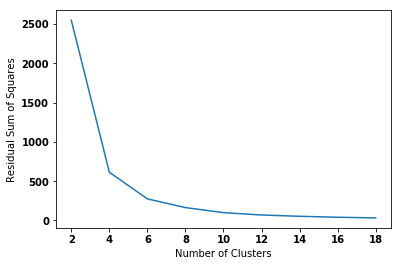

In [95]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans

def kmean_rss_score(nclust):
    km = Pipeline([('hash', HashingVectorizer()),
                   ('svd', TruncatedSVD()),
                   ('norm', Normalizer()),
                   ('cluster', KMeans(nclust))])
    km.fit(X_train_str)
    rss = -km.score(X_train_str)
    return rss

clusts = range(2,20,2)

rss = [kmean_rss_score(i) for i in clusts]
plt.plot(clusts, rss)
plt.xlabel('Number of Clusters')
plt.ylabel('Residual Sum of Squares')

In [96]:
km = Pipeline([('hash', HashingVectorizer()),
               ('svd', TruncatedSVD()),
               ('norm', Normalizer()),
               ('cluster', KMeans(n_clusters=6))])

km.fit(X_train_str)

Pipeline(memory=None,
     steps=[('hash', HashingVectorizer(alternate_sign=True, analyzer='word', binary=False,
         decode_error='strict', dtype=<class 'numpy.float64'>,
         encoding='utf-8', input='content', lowercase=True,
         n_features=1048576, ngram_range=(1, 1), non_negative=False,
         norm='l2', pr...6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))])

In [97]:
cluster_train = pd.DataFrame([X_train_str, y_train]).transpose()
cluster_train['cluster'] = km.predict(cluster_train['ingredients'])

cluster_dev = pd.DataFrame([X_dev_str, y_dev]).transpose()
cluster_dev['cluster'] = km.predict(cluster_dev['ingredients'])

In [98]:
cluster_dev['cluster'].value_counts()

3    2207
1    2014
2    1939
5    1487
4    1228
0    1069
Name: cluster, dtype: int64

In [104]:
cluster_dev['count'] = cluster_dev['ingredients'].apply(lambda x: len(re.findall(',',x))+1)

In [107]:
cluster_dev.groupby('cluster').mean()

,count
cluster,
0,9.947615
1,12.356504
2,11.835482
3,10.433167
4,8.470684
5,10.694015


In [87]:
(2057*0.79436) + (1227*0.61695191524) + (2228*0.81552962298) + (1455*0.739518900344) + (1057*0.64711447492) + (1920*0.7765625)

7458.99851998988

In [89]:
7458.9985199898/ len(cluster_dev)

0.7501004143191673

In [108]:
svc_pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words='english',analyzer="word", token_pattern=r'\w+')),
    ('svm', LinearSVC(penalty='l2')),
])

In [109]:
search_params = {
    'tfidf__max_features': [3000, 3050, 3100, 3150],
    'svm__C': [0.45, 0.475, .5 , 0.525, 0.55]
}

grid_search = GridSearchCV(svc_pipe, search_params, verbose=1)

temp_train = cluster_train[cluster_train['cluster']==0]
temp_dev = cluster_dev[cluster_dev['cluster']==0]
grid_search.fit(temp_train['ingredients'], temp_train['cuisine'])
print(grid_search.best_params_)
print(grid_search.score(temp_dev['ingredients'], temp_dev['cuisine']))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   19.3s finished


{'svm__C': 0.45, 'tfidf__max_features': 3000}
0.650140318054


In [110]:
search_params = {
    'tfidf__max_features': [2100, 2200, 2300],
    'svm__C': [0.45, 0.5, 0.55]
}

grid_search = GridSearchCV(svc_pipe, search_params, verbose=1)

temp_train = cluster_train[cluster_train['cluster']==1]
temp_dev = cluster_dev[cluster_dev['cluster']==1]
grid_search.fit(temp_train['ingredients'], temp_train['cuisine'])
print(grid_search.best_params_)
print(grid_search.score(temp_dev['ingredients'], temp_dev['cuisine']))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   16.1s finished


{'svm__C': 0.5, 'tfidf__max_features': 2100}
0.788480635551


In [111]:
search_params = {
    'tfidf__max_features': [3400, 3500, 3600],
    'svm__C': [0.45, 0.5, 0.55]
}

grid_search = GridSearchCV(svc_pipe, search_params, verbose=1)

temp_train = cluster_train[cluster_train['cluster']==2]
temp_dev = cluster_dev[cluster_dev['cluster']==2]
grid_search.fit(temp_train['ingredients'], temp_train['cuisine'])
print(grid_search.best_params_)
print(grid_search.score(temp_dev['ingredients'], temp_dev['cuisine']))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   14.5s finished


{'svm__C': 0.55, 'tfidf__max_features': 3400}
0.773594636411


In [112]:
search_params = {
    'tfidf__max_features': [2500, 3000, 3500],
    'svm__C': [0.4, 0.5, 0.6]
}

grid_search = GridSearchCV(svc_pipe, search_params, verbose=1)

temp_train = cluster_train[cluster_train['cluster']==3]
temp_dev = cluster_dev[cluster_dev['cluster']==3]
grid_search.fit(temp_train['ingredients'], temp_train['cuisine'])
print(grid_search.best_params_)
print(grid_search.score(temp_dev['ingredients'], temp_dev['cuisine']))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   16.0s finished


{'svm__C': 0.5, 'tfidf__max_features': 3000}
0.813321250566


In [113]:
search_params = {
    'tfidf__max_features': [2000, 3000, 4000],
    'svm__C': [0.2, 0.5, 0.8]
}

grid_search = GridSearchCV(svc_pipe, search_params, verbose=1)

temp_train = cluster_train[cluster_train['cluster']==4]
temp_dev = cluster_dev[cluster_dev['cluster']==4]
grid_search.fit(temp_train['ingredients'], temp_train['cuisine'])
print(grid_search.best_params_)
print(grid_search.score(temp_dev['ingredients'], temp_dev['cuisine']))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    9.5s finished


{'svm__C': 0.8, 'tfidf__max_features': 2000}
0.615635179153


In [114]:
search_params = {
    'tfidf__max_features': [2500, 3000, 3500],
    'svm__C': [0.4, 0.5, 0.6]
}

grid_search = GridSearchCV(svc_pipe, search_params, verbose=1)

temp_train = cluster_train[cluster_train['cluster']==5]
temp_dev = cluster_dev[cluster_dev['cluster']==5]
grid_search.fit(temp_train['ingredients'], temp_train['cuisine'])
print(grid_search.best_params_)
print(grid_search.score(temp_dev['ingredients'], temp_dev['cuisine']))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   10.6s finished


{'svm__C': 0.5, 'tfidf__max_features': 3000}
0.740416946873


NameError: name 'cluster_dev' is not defined

## Final Data Preparation

TBD

## Final Data Modeling

TBD

## Evaluation

TBD

## Deployment

Deployment is out of scope of this project, since there is no deployment in the deliverable other than this notebook.

## Scratch

In [43]:
X_test_str = X_test.apply(list_to_string)
test_pred = base_pipeline.predict(X_test_str)

In [44]:
submission = pandas.DataFrame([test['id'], test_pred]).T
submission.columns = ['id', 'cuisine']

In [47]:
submission.to_csv("submission.csv", index = False)

In [45]:
submission

,id,cuisine
0,18009,british
1,28583,southern_us
2,41580,italian
3,29752,cajun_creole
4,35687,italian
5,38527,southern_us
6,19666,spanish
7,41217,chinese
8,28753,mexican
9,22659,moroccan


In [116]:
from textblob import TextBlob

In [19]:
for i in X_train_all[:10]:
    txt = ', '.join(i)
    blob = TextBlob(txt)
    print(txt)
    print(blob.noun_phrases)
    print([n for n,t in blob.tags if t in ('NN','NNS')])
    print()

romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanzo beans, feta cheese crumbles
['romaine lettuce', 'black olives', 'grape tomatoes', 'purple onion', 'garbanzo beans', 'feta cheese crumbles']
['romaine', 'lettuce', 'olives', 'grape', 'tomatoes', 'garlic', 'pepper', 'onion', 'beans', 'crumbles']

plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, yellow corn meal, milk, vegetable oil
['plain flour', 'ground pepper', 'black pepper', 'green tomatoes', 'yellow corn meal', 'vegetable oil']
['ground', 'pepper', 'salt', 'tomatoes', 'ground', 'pepper', 'thyme', 'eggs', 'tomatoes', 'corn', 'meal', 'milk', 'oil']

eggs, pepper, salt, mayonaise, cooking oil, green chilies, grilled chicken breasts, garlic powder, yellow onion, soy sauce, butter, chicken livers
['cooking oil', 'green chilies', 'chicken breasts', 'garlic powder', 'yellow onion', 'soy sauce', 'chicken livers']
['eggs', 'pepper', 'salt', 'mayonaise

In [17]:
blob.tags

[('chopped', 'NN'),
 ('tomatoes', 'NNS'),
 ('fresh', 'JJ'),
 ('basil', 'NN'),
 ('garlic', 'JJ'),
 ('extra-virgin', 'JJ'),
 ('olive', 'JJ'),
 ('oil', 'NN'),
 ('kosher', 'NN'),
 ('salt', 'NN'),
 ('flat', 'JJ'),
 ('leaf', 'NN'),
 ('parsley', 'NN')]

In [20]:
blob.tokens

WordList(['chopped', 'tomatoes', ',', 'fresh', 'basil', ',', 'garlic', ',', 'extra-virgin', 'olive', 'oil', ',', 'kosher', 'salt', ',', 'flat', 'leaf', 'parsley'])

In [117]:
blob = TextBlob('The quick brown fox jumped over the laxy dog')

In [136]:
blob = TextBlob('poisson')

TextBlob.detect_language(blob)

'fr'